# RL homework 1
**Due date: 19 February 2017, 11:55pm (just before mid-night!)**


Student name: Bing CHEN

student number: 17028246

## How to submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as studentnumber_DL_hw2.ipynb before the deadline above.

Also send a sharable link to the notebook at the following email: ucl.coursework.submit@gmail.com. You can also make it sharable via link to everyone, up to you.

## Context

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

## Background reading

* Sutton and Barto (2018), Chapters 1 and 2

# The Assignment

### Objectives

You will use Python to implement several bandit algorithms.

You will then run these algorithms on a multi-armed Bernoulli bandit problem, to understand the issue of balancing exploration and exploitation.

# Setup

### Import Useful Libraries

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [0]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

### A generic multi-armed bandit class, with Bernoulli rewards

In [0]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""
  
  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or tf.int32 that specifies which arm to pull.

    Returns:
      A sampled reward according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

### Helper functions

In [0]:
def smooth(array, smoothing_horizon=100., initial_value=0.):
  """smoothing function for plotting"""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot"""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, optimal_value, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 3
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(15, 5*n_rows))
  
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)
      ax.set_axis_bgcolor('white')

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg in current_algs:
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.6, label=alg.name)[0]
        else:
          line = plt.plot(m, alpha=0.6, label=alg.name)[0]
          plt.fill_between(range(number_of_steps), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if not p.log_plot:
        plt.plot([0, number_of_steps], [optimal_value]*2, '--k', label='optimal')

      plt.ylim(p.ylim)
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit, algs, repetitions):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}

  for alg in algs:
    reward_dict[alg.name] = []
    action_dict[alg.name] = []

    for _ in range(repetitions):
      alg.reset()
      reward_dict[alg.name].append([])
      action_dict[alg.name].append([])
      action = None
      reward = None
      for i in range(number_of_steps):
        try:
          action = alg.step(action, reward)
        except:
          print(alg, action, reward)
          #aoushd()
          raise
        reward = bandit.step(action)
        reward_dict[alg.name][-1].append(reward)
        action_dict[alg.name][-1].append(action)
        
  return reward_dict, action_dict

def train_agents(agents, number_of_arms, number_of_steps, repetitions=30,
                 success_reward=1., fail_reward=0.):

  success_probabilities = np.arange(0.25, 0.75 + 1e-6, 0.5/(number_of_arms - 1))
  bandit = BernoulliBandit(success_probabilities, success_reward, fail_reward)

  max_p = np.max(success_probabilities)
  min_p = np.min(success_probabilities)
  ylim_max = max_p*success_reward + (1 - max_p)*fail_reward
  ylim_min = min_p*success_reward + (1 - min_p)*fail_reward
  dif = ylim_max - ylim_min
  ylim = (ylim_min - 0.1*dif, ylim_max + 0.1*dif)

  max_prob = np.max(success_probabilities)
  optimal_value = max_prob*success_reward + (1 - max_prob)*fail_reward

  reward_dict, action_dict = run_experiment(bandit, agents, repetitions)
  
  smoothed_rewards = {}
  expected_rewards = {}
  regrets = {}
  for agent, rewards in reward_dict.items():
    smoothed_rewards[agent] = np.array(rewards)
  for agent, actions in action_dict.items():
    p_success = one_hot(actions, number_of_arms).dot(success_probabilities)
    expected_rewards[agent] = p_success*success_reward + (1 - p_success)*fail_reward
    regrets[agent] = optimal_value - expected_rewards[agent]

  PlotData = namedtuple('PlotData', ['title', 'data', 'log_plot', 'ylim'])
  plot_data = [
      PlotData(title='Smoohted rewards', data=smoothed_rewards,
               log_plot=False, ylim=ylim),
      PlotData(title='Expected rewards', data=expected_rewards,
               log_plot=False, ylim=ylim),
      PlotData(title='Current Regret', data=regrets,
               log_plot=True, ylim=(1e-2, 1)),
      PlotData(title='Total Regret',
               data=dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()]),
               log_plot=False, ylim=(1e-0, 5e2)),
  ]

  plot(agents, plot_data, optimal_value)

### Random agent

In [0]:
class Random(object):
  """A random agent.
  
  This agent returns an action between 0 and 'number_of_arms', 
  uniformly at random. The 'previous_action' argument of 'step'
  is ignored.
  """

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'random'
    self.reset()

  def step(self, previous_action, reward):
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass

# A1: Implement agents

Each agent, should implement the following methods:

### `step(self, previous_action, reward)`:
should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

### `reset(self)`:
resets statistics (should be equivalent to constructing a new agent from scratch).  Make sure that the initial values (after a reset) are all zero.

### `__init__(self)`:
The `__init__` can be *the same* as for the random agent above (with the exception of $\epsilon$-greedy---see below), except for the name, which should be unique (e.g., 'greedy', 'ucb', etc.)

All agents should be in pure Python - so you cannot use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.



## Agent 1: greedy
**[10 pts]** You should **implement the greedy** agent, that

1.   Estimates the average reward for each action that was selected so far, and
2.   Always selects the highest-valued action.


In [0]:
class Greedy(object):

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'greedy'
    self.reset()
  
  def step(self, previous_action, reward):
 
    if previous_action == None:
      return np.random.randint(self._number_of_arms)
    else:
      
      self.Nt[previous_action] +=1
      self.Qt[previous_action] = self.Qt[previous_action] + (reward-self.Qt[previous_action])/self.Nt[previous_action]      
      return np.argmax(np.random.random(self.Qt.shape) * (self.Qt==self.Qt.max()))
       
    
  def reset(self):
    self.Qt = np.zeros(self._number_of_arms)
    self.Nt = np.zeros(self._number_of_arms)



## Agent 2: $\epsilon$-greedy
**[15 pts]** You should **implement an $\epsilon$-greedy** agent, that selects the highest-valued action with probability $1 - \epsilon$, and otherwise selects an action at random.

The exploration parameter $\epsilon$ should be given in the `__init__`, as indicated in the code below.


In [0]:
class EpsilonGreedy(object):

  def __init__(self, number_of_arms, epsilon=0.1):
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.name = 'epsilon-greedy epsilon:{}'.format(epsilon)
    self.reset()
  
  def step(self, previous_action, reward):

    if previous_action == None:
      return np.random.randint(self._number_of_arms)
    
    else:  
      self.Nt[previous_action] +=1
      self.Qt[previous_action] = self.Qt[previous_action] + (reward-self.Qt[previous_action])/self.Nt[previous_action]
      if bool(np.random.random() > self._epsilon):
        return np.argmax(np.random.random(self.Qt.shape) * (self.Qt==self.Qt.max()))#np.argmax(self.Qt,tie_breaking=np.random.choice)#
      #np.argmax(a,tie_breaking=random.choice)
      
      else:
        return np.random.randint(self._number_of_arms)
    
  def reset(self):
    self.Qt = np.zeros(self._number_of_arms)
    self.Nt = np.zeros(self._number_of_arms)
 


## Agent 3: UCB
**[15 pt]** You should **implement** an agent that **explores with UCB**. 


In [0]:
class UCB(object):

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'ucb'
    self.reset()
  
  def step(self, previous_action, reward):
    self.times += 1
    c = 1 
    if previous_action == None:
      return np.random.randint(self._number_of_arms)
    else:      
      self.Nt[previous_action] +=1
      self.Qt[previous_action] = self.Qt[previous_action] + (reward-self.Qt[previous_action])/self.Nt[previous_action]
      ucb =self.Qt + c*np.sqrt(np.log(self.times)/self.Nt)
      return np.argmax(np.random.random(ucb.shape) * (ucb==ucb.max())) #ucb.argmax()
      
    
  def reset(self):
    self.Qt = [0]*self._number_of_arms
    self.Nt = [0]*self._number_of_arms
    self.times = 0



## Agent 4: REINFORCE agents
You should implement agents that implement REINFORCE policy-gradient methods

The policy should be a softmax on action preferences:
$$\pi(a) = \frac{\exp(p(a))}{\sum_b \exp(p(b))}\,.$$

The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.



## Assignment 4a:
In the next text field, write down the update function to the preferences for all actions $\{a_1, \ldots, a_n\}$ if you selected a specific action $A_t = a_i$ and received a reward of $R_t$.

In other words, complete:
\begin{align*}
p_{t+1}(a) 
& = \ldots
&& \text{for $a = A_t$} \\
p_{t+1}(b)
&=\ldots
&& \text{for all $b \ne A_t$}
\end{align*}

**[10 pts]** **Instructions**: please provide answer in markdown below.



\begin{align*}
p_{t+1}(a) = p_{t}(a) + \alpha(R_{t}-\bar R_{t})(1-\pi_{t}(a))
& 
&& \text{for $a = A_t$} \\
p_{t+1}(b)=p_{t}(b) - \alpha(R_{t}-\bar R_{t})\pi_{t}(b)
&
&& \text{for all $b \ne A_t$}
\end{align*}


## Assignment 4b:
**[15 + 5 pts]** You should **implement a vanilla REINFORCE agent with** and **without a baseline**.
Whether or not a baseline is used should be a boolean constructor argument.

In [0]:
class REINFORCE(object):
 
  def __init__(self, number_of_arms, step_size=0.1, baseline=False):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self.name = 'reinforce, baseline: {}'.format(baseline)
    self._baseline = baseline
    self.reset()
  
  def step(self, previous_action, reward):
    a = np.arange(self._number_of_arms)
    #print(str(self.times))

    if previous_action == None:
      self.pi = np.exp(self.Ht)/np.sum(np.exp(self.Ht))
      return np.random.randint(self._number_of_arms)
    else:
      if self._baseline == False:  
        self.ave_reward = 0
      #self.Ht = self.Ht + self._lr*reward*((a==previous_action)-self.pi)
      #self.pi = np.exp(self.Ht)/np.sum(np.exp(self.Ht))
      #return np.random.choice(a, p=self.pi)
      else:
        self.times += 1
        self.ave_reward =self.ave_reward + (reward-self.ave_reward)/self.times
      self.Ht = self.Ht + self._lr*(reward-self.ave_reward )*((a==previous_action)-self.pi)
      self.pi = np.exp(self.Ht)/np.sum(np.exp(self.Ht))
      return np.random.choice(a, p=self.pi)#np.argmax(np.random.random(self.pi.shape) * (self.pi==self.pi.max()))#self.pi.argmax()
    
    

  def reset(self):
    self.ave_reward = 0
    self.times = 0
    self.Ht = np.zeros(self._number_of_arms)
    self.pi = np.zeros(self._number_of_arms)

           

# Assignment 5: Analyse Results

### Run the cell below to train the agents and generate the plots for the first experiment.

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


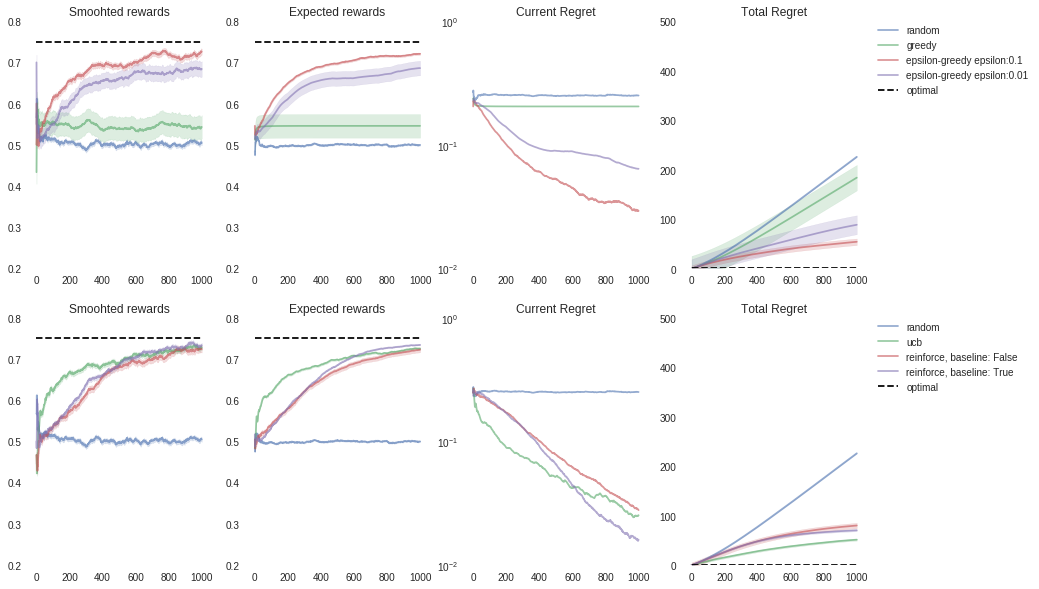

In [65]:
#@title Experiment 1: Bernoulli bandit

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(number_of_arms),
    Greedy(number_of_arms),
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    REINFORCE(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

## Assignment 5 a.
(Answer inline in the markdown below each question.)

**[5pts]** Name the best and worst algorithms, and explain (with one or two sentences each) why these are best and worst.

*Answer here.*
>The best algorithm is the reinforce with baseline algorithm. In the graphs, reinforce with baseline algorithm has the largest rewards finally. Although its regret is large at the beginning, which results in the high total regret, the current regret decreases all the time and finally is very small and the total regret becomes steady.

>The worst algorithm is random. From the graphs, its rewards are quite low compared with others algorithms and its regret is constant and larger than other algorithms. Moreover, the total regret increase all the time.
hich results in the high total regret, the current regret decreases all the time and finally be very small and the total regret becomes steady.


**[5pts]** Which algorithms are guaranteed to have linear total regret?

*Answer here.*

>Random, greedy, and greedy with epsilon algorithm have the linear total regret.


**[5pts]** Which algorithms are guaranteed to have logarithmic total regret?

*Answer here.*
>UCB has logarithmic total regret.

**[5pts]** Which of the $\epsilon$-greedy algorithms performs best?  Which should perform best in the long run?

*Answer here.*
>Epsilon-greedy with epsilon 0.1 performs better here. In the long run, epsilon-greedy with epsilon 0.01 will perform better. 
With a larger epsilon value means to explore more and achieve the optimal earlier. In a short term, a small epsilon (0.01) may results in explore less, exploit the suboptimal too much and reach the optimal late or even cannot reach the optimal. However, in the long run, although epsilon-greedy with epsilon 0.1 finds the optimal action earlier, it selects the optimal action less (no more than 91% of the time). And epsilon-greedy with epsilon 0.01algorithm finds the optimal action slowly but selects the optimal more often (nearly 99% of the time). Hence, in the long run, epsilon-greedy with epsilon 0.01 perform better.


### Run the cell below to train the agents and generate the plots for the second experiment.

Trains the agents on a bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


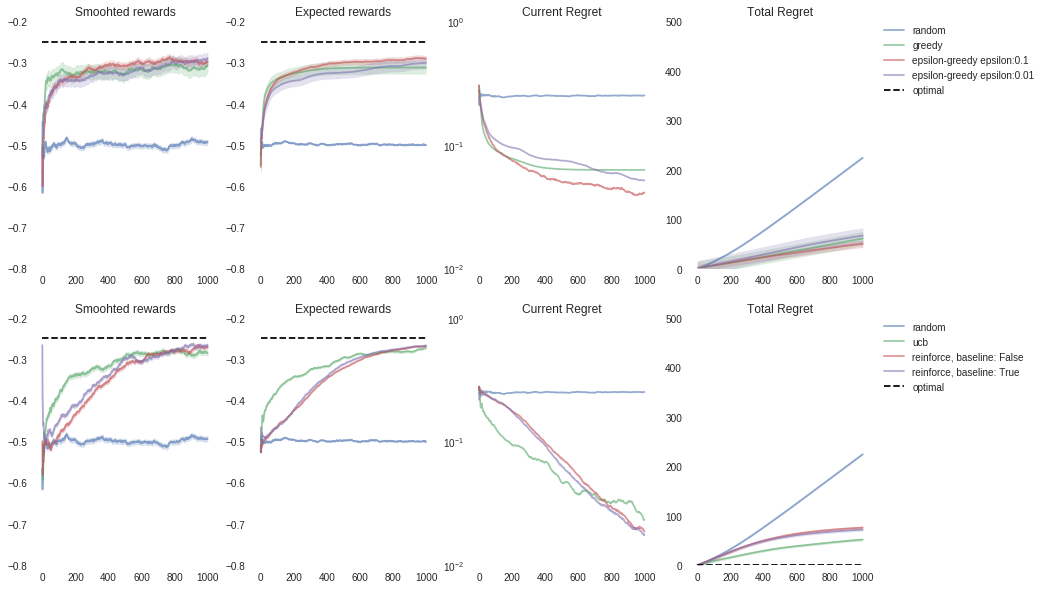

In [66]:
#@title Experiment 2: R = 0 on success, R = -1 on failure.
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

## Assignment 5 b.
(Answer inline in the markdown.)

**[10pts]** Explain which algorithms improved from the changed rewards, and why.

(Use at most two sentences per algorithm and feel free to combine explanations for different algorithms where possible).

*Answer here*

Greedy algorithm, epsilon-greedy (0.01) algorithm and epsilon-greedy (0.1) algorithm improved from the changed rewards.
The greedy algorithm improved from changed rewards. Its reward largely improved and its regret decrease. Greedy algorithm is to choose the action with maximum action value. In the previous example (success_reward=1, fail_reward = 0), the initialization of action value is all equals zeros. Then no matter which action are chosen, if the reward is 1, the greedy algorithm will lock on this action and keep choosing this action since the action value of this action larger than zero. Therefore, greedy algorithm locks on suboptimal action easily in the previous example. After changing the rewards to success_reward=0, fail_reward = -1, no matter which action is chosen and which reward is returned, the other actions still have chance to be chosen since 0 is the maximum in this example. Greedy algorithm will not lock to one action and it explore more actions in the latter example.

The epsilon-greedy (0.01) algorithm improved from changed rewards. Its reward improved and its regret decrease. Moreover, it reaches optimal earlier. Like greedy algorithm, changing reward from (success_reward=1, fail_reward = 0) to (success_reward=0, fail_reward = -1) allows epsilon-greedy (0.01) algorithm to explore more action during greedy process, which enables epsilon-greedy (0.01) to explore more action and therefore less likely to lock on its suboptimal and reach its optimal earlier. 

The epsilon-greedy (0.1) algorithm improved from changed rewards. It reaches optimal earlier. Like greedy algorithm, changing reward from (success_reward=1, fail_reward = 0) to (success_reward=0, fail_reward = -1) allows epsilon-greedy (0.1) algorithm to explore more action during greedy process, which enables epsilon-greedy (0.01) to reach its optimal earlier. 

The UCB, reinforce with baseline and reinforce without baseline algorithm do not show obvious improvement.  
